**IMPORT LIBRARY**

In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType, TimestampType, IntegerType
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import abs, desc
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType
#Library untuk Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np



1. **Pembuatan SparkSession**

In [36]:
spark = SparkSession.builder \
    .appName("NYCTaxi") \
    .getOrCreate()

print("SparkSession berhasil dibuat:")
print(spark)

SparkSession berhasil dibuat:


2. **Load dan Tampilkan Data**

In [37]:
spark = SparkSession.builder.getOrCreate()

# 1. Tentukan Skema Data
schema = StructType([
    StructField("key", StringType(), True),
    StructField("fare_amount", FloatType(), True),
    StructField("pickup_datetime", StringType(), True),
    StructField("pickup_longitude", FloatType(), True),
    StructField("pickup_latitude", FloatType(), True),
    StructField("dropoff_longitude", FloatType(), True),
    StructField("dropoff_latitude", FloatType(), True),
    StructField("passenger_count", IntegerType(), True)
])

# 2. Muat Seluruh Data
print("Mulai memuat data 'train.csv'...")
df_py = spark.read.csv(
    'train.csv',
    header=True,
    schema=schema
)
print("Data selesai dimuat.")

# 3. Tampilkan Hasil
print("\nSkema DataFrame kita:")
df_py.printSchema()

print("\nContoh 5 baris data pertama:")
df_py.show(5, truncate=False)

# 4. Hitung jumlah total baris
total_rows = df_py.count()
print(f"\nJumlah total baris dalam data: {total_rows}")

Mulai memuat data 'train.csv'...
Data selesai dimuat.

Skema DataFrame kita:
root
 |-- key: string (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: float (nullable = true)
 |-- pickup_latitude: float (nullable = true)
 |-- dropoff_longitude: float (nullable = true)
 |-- dropoff_latitude: float (nullable = true)
 |-- passenger_count: integer (nullable = true)


Contoh 5 baris data pertama:
+-----------------------------+-----------+-----------------------+----------------+---------------+-----------------+----------------+---------------+
|key                          |fare_amount|pickup_datetime        |pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-----------------------------+-----------+-----------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15 17:26:21.0000001  |4.5        |2009-06-15 17:26:21 UTC|-73.

3. **Statistika Deskriptif Awal (Sebelum dibersihkan)**

In [38]:
# 1. Statistik Deskriptif
print("Statistik Deskriptif Awal:")
df_py.select("fare_amount", 
             "pickup_longitude", 
             "pickup_latitude", 
             "dropoff_longitude", 
             "dropoff_latitude", 
             "passenger_count") \
     .describe() \
     .show()

# 2. Cek Nilai Null (Data Hilang)
print("\nMenghitung Nilai Null:")
df_py.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_py.columns]).show()

Statistik Deskriptif Awal:
+-------+------------------+------------------+-----------------+------------------+----------------+------------------+
|summary|       fare_amount|  pickup_longitude|  pickup_latitude| dropoff_longitude|dropoff_latitude|   passenger_count|
+-------+------------------+------------------+-----------------+------------------+----------------+------------------+
|  count|             50000|             50000|            50000|             50000|           50000|             50000|
|   mean|11.364171422414966| -72.5097555850712|39.93375897353329|-72.50461601842936|39.9262514114378|           1.66784|
| stddev|  9.68555751823222|10.393860223603454|6.224857181308011|10.407569606011792|6.01473670016731|1.2891947001362873|
|    min|              -5.0|         -75.42385|        -74.00689|         -84.65424|       -74.00638|                 0|
|    max|             200.0|          40.78347|        401.08334|          40.85103|        43.41519|                 6|
+----

4. **Pembersihan Data**

In [39]:
# 3. Proses Pembersihan Data
df_py_no_nulls = df_py.dropna(subset=[
    "fare_amount", "pickup_datetime", "pickup_longitude", "pickup_latitude",
    "dropoff_longitude", "dropoff_latitude", "passenger_count"
])

NYC_BOUNDS = {
    'min_lon': -74.25, 'max_lon': -73.7,
    'min_lat': 40.5, 'max_lat': 40.9
}

df_py_cleaned = df_py_no_nulls.filter(
    (F.col("fare_amount") > 2.5) & (F.col("fare_amount") < 500) &
    (F.col("passenger_count") > 0) & (F.col("passenger_count") < 7) &
    (F.col("pickup_longitude").between(NYC_BOUNDS['min_lon'], NYC_BOUNDS['max_lon'])) &
    (F.col("pickup_latitude").between(NYC_BOUNDS['min_lat'], NYC_BOUNDS['max_lat'])) &
    (F.col("dropoff_longitude").between(NYC_BOUNDS['min_lon'], NYC_BOUNDS['max_lon'])) &
    (F.col("dropoff_latitude").between(NYC_BOUNDS['min_lat'], NYC_BOUNDS['max_lat']))
)

# 4. Bandingkan Jumlah Data
print("\nPerbandingan Jumlah Data:")
print(f"Jumlah data asli: {df_py.count()}")
print(f"Jumlah data setelah dibersihkan: {df_py_cleaned.count()}")

#Sebelum Dibersihkan
print("\nStatistik Deskriptif Awal:")
df_py.select("fare_amount", 
             "pickup_longitude", 
             "pickup_latitude", 
             "dropoff_longitude", 
             "dropoff_latitude", 
             "passenger_count") \
     .describe() \
     .show()

# 5. Tampilkan Statistik Deskriptif
#Setelah dibersihkan
print("\nStatistik Deskriptif Setelah Dibersihkan:")
df_py_cleaned.select("fare_amount", 
             "pickup_longitude", 
             "pickup_latitude", 
             "dropoff_longitude", 
             "dropoff_latitude", 
             "passenger_count") \
     .describe() \
     .show()


Perbandingan Jumlah Data:
Jumlah data asli: 50000
Jumlah data setelah dibersihkan: 48525

Statistik Deskriptif Awal:
+-------+------------------+------------------+-----------------+------------------+----------------+------------------+
|summary|       fare_amount|  pickup_longitude|  pickup_latitude| dropoff_longitude|dropoff_latitude|   passenger_count|
+-------+------------------+------------------+-----------------+------------------+----------------+------------------+
|  count|             50000|             50000|            50000|             50000|           50000|             50000|
|   mean|11.364171422414966| -72.5097555850712|39.93375897353329|-72.50461601842936|39.9262514114378|           1.66784|
| stddev|  9.68555751823222|10.393860223603454|6.224857181308011|10.407569606011792|6.01473670016731|1.2891947001362873|
|    min|              -5.0|         -75.42385|        -74.00689|         -84.65424|       -74.00638|                 0|
|    max|             200.0|       

5. **Feature Engineering**

In [40]:
# 1. FITUR WAKTU
print("Membuat fitur-fitur waktu...")

df_with_timestamp = df_py_cleaned.withColumn("pickup_datetime_ts", F.to_timestamp(F.col("pickup_datetime")))
df_with_time_features = df_with_timestamp.withColumn("hour", F.hour(F.col("pickup_datetime_ts")))
df_with_time_features = df_with_time_features.withColumn("day_of_week", F.dayofweek(F.col("pickup_datetime_ts")))
df_with_time_features = df_with_time_features.withColumn("month", F.month(F.col("pickup_datetime_ts")))
df_with_time_features = df_with_time_features.withColumn("year", F.year(F.col("pickup_datetime_ts")))

# 2. FITUR JARAK (HAVERSINE)
print("Membuat fitur jarak (Haversine)...")

R = 6371.0  # Radius bumi dalam KM

lon1_rad = F.radians(F.col("pickup_longitude"))
lat1_rad = F.radians(F.col("pickup_latitude"))
lon2_rad = F.radians(F.col("dropoff_longitude"))
lat2_rad = F.radians(F.col("dropoff_latitude"))

# Perbedaan delta
dlon = lon2_rad - lon1_rad
dlat = lat2_rad - lat1_rad

# Rumus Haversine
a = F.sin(dlat / 2)**2 + F.cos(lat1_rad) * F.cos(lat2_rad) * F.sin(dlon / 2)**2
c = 2 * F.atan2(F.sqrt(a), F.sqrt(1 - a))

# Jarak dalam KM
distance_col = F.lit(R) * c

# Tambahkan sebagai kolom baru
df_py_features = df_with_time_features.withColumn("distance_km", distance_col)

# 3. Fitur Jarak Sederhana
df_py_features = df_py_features.withColumn("abs_lon_diff", F.abs(F.col("dropoff_longitude") - F.col("pickup_longitude")))
df_py_features = df_py_features.withColumn("abs_lat_diff", F.abs(F.col("dropoff_latitude") - F.col("pickup_latitude")))

# 4. TAMPILKAN HASIL
print("\nData dengan Fitur-Fitur Baru:")
df_py_features.select(
    "fare_amount",    
    "distance_km",    
    "hour",           
    "day_of_week",    
    "passenger_count"
).show(10)

print("\nSkema Baru:")
df_py_features.printSchema()

Membuat fitur-fitur waktu...
Membuat fitur jarak (Haversine)...

Data dengan Fitur-Fitur Baru:
+-----------+------------------+----+-----------+---------------+
|fare_amount|       distance_km|hour|day_of_week|passenger_count|
+-----------+------------------+----+-----------+---------------+
|        4.5| 1.030742156076421|   0|          3|              1|
|       16.9| 8.450000407101376|  23|          3|              1|
|        5.7| 1.389631940297322|   7|          5|              2|
|        7.7|2.7992105002075935|  11|          7|              1|
|        5.3|1.9990814399388632|  14|          3|              1|
|       12.1| 3.787117925455816|  16|          5|              1|
|        7.5|1.5558597970429915|   3|          4|              1|
|       16.5| 4.155500356130715|   0|          5|              1|
|        9.0|1.2531807161405653|  20|          2|              1|
|        8.9|2.8495899671036886|   8|          4|              2|
+-----------+------------------+----+----------

6. **Vektorisasi untuk ML**

In [41]:
# 1. Tentukan kolom-kolom fitur kita
feature_cols = [
    "distance_km",
    "hour",
    "day_of_week",
    "month",
    "year",
    "passenger_count",
    "abs_lon_diff",
    "abs_lat_diff"
]

# 2. Inisialisasi VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# 3. "Transformasi" data kita
df_assembled = assembler.transform(df_py_features)

# 4. Siapkan Data Akhir untuk Model
final_data = df_assembled.select(
    col("features"), 
    col("fare_amount").alias("label")
)

print("Data Akhir (Siap untuk Model):")
final_data.printSchema()
final_data.show(5, truncate=False)

# 5. Membagi Data (Split Data)
(train_data, test_data) = final_data.randomSplit([0.8, 0.2], seed=42)

print("\nData telah dibagi:")
print(f"Jumlah data Latih (Train): {train_data.count()}")
print(f"Jumlah data Uji (Test):   {test_data.count()}")

Data Akhir (Siap untuk Model):
root
 |-- features: vector (nullable = true)
 |-- label: float (nullable = true)

+------------------------------------------------------------------------------------+-----+
|features                                                                            |label|
+------------------------------------------------------------------------------------+-----+
|[1.030742156076421,0.0,3.0,6.0,2009.0,1.0,0.0027008056640625,0.00904083251953125]   |4.5  |
|[8.450000407101376,23.0,3.0,1.0,2010.0,1.0,0.036773681640625,0.07070159912109375]   |16.9 |
|[1.389631940297322,7.0,5.0,8.0,2011.0,2.0,0.00850677490234375,0.010707855224609375] |5.7  |
|[2.7992105002075935,11.0,7.0,4.0,2012.0,1.0,0.0044403076171875,0.0249481201171875]  |7.7  |
|[1.9990814399388632,14.0,3.0,3.0,2010.0,1.0,0.01143646240234375,0.01575469970703125]|5.3  |
+------------------------------------------------------------------------------------+-----+
only showing top 5 rows

Data telah dibagi:
Jumlah

7. **Training Model**

In [42]:
# 1. MODEL 1: LINEAR REGRESSION (Baseline)
print("Memulai training Linear Regression...")

# Inisialisasi model
lr = LinearRegression(featuresCol="features", labelCol="label")

# Latih model
lr_model = lr.fit(train_data)

# Buat prediksi di data UJI (data yang belum pernah dilihat)
lr_predictions = lr_model.transform(test_data)

print("Linear Regression Selesai.")

# 2. MODEL 2: RANDOM FOREST REGRESSOR
print("\nMemulai training Random Forest...")

# Inisialisasi model
rf = RandomForestRegressor(featuresCol="features", labelCol="label", seed=42)

# Latih model
rf_model = rf.fit(train_data)

# Buat prediksi di data UJI
rf_predictions = rf_model.transform(test_data)

print("Random Forest Selesai.")

# 3. EVALUASI MODEL
print("\n--- Hasil Evaluasi Model ---")

# Inisialisasi evaluator untuk RMSE
evaluator_rmse = RegressionEvaluator(labelCol="label", 
                                      predictionCol="prediction", 
                                      metricName="rmse")

# Inisialisasi evaluator untuk R2
evaluator_r2 = RegressionEvaluator(labelCol="label", 
                                   predictionCol="prediction", 
                                   metricName="r2")

# Hitung metrik untuk Linear Regression
lr_rmse = evaluator_rmse.evaluate(lr_predictions)
lr_r2 = evaluator_r2.evaluate(lr_predictions)

# Hitung metrik untuk Random Forest
rf_rmse = evaluator_rmse.evaluate(rf_predictions)
rf_r2 = evaluator_r2.evaluate(rf_predictions)

# Tampilkan hasil perbandingan
print("\nModel Linear Regression:")
print(f"  RMSE: {lr_rmse:.2f}")
print(f"  R²:   {lr_r2:.4f}")

print("\nModel Random Forest:")
print(f"  RMSE: {rf_rmse:.2f}")
print(f"  R²:   {rf_r2:.4f}")

print("\nContoh Prediksi (Random Forest):")
# 'prediction' = hasil tebakan model
# 'label' = nilai asli
rf_predictions.select("prediction", "label", "features").show(10, truncate=False)

Memulai training Linear Regression...
Linear Regression Selesai.

Memulai training Random Forest...
Random Forest Selesai.

--- Hasil Evaluasi Model ---

Model Linear Regression:
  RMSE: 4.32
  R²:   0.7889

Model Random Forest:
  RMSE: 4.28
  R²:   0.7926

Contoh Prediksi (Random Forest):
+------------------+-----+-------------------------------------+
|prediction        |label|features                             |
+------------------+-----+-------------------------------------+
|10.094395189668614|9.7  |(8,[2,3,4,5],[2.0,8.0,2012.0,1.0])   |
|10.140032076348184|4.5  |(8,[2,3,4,5],[3.0,12.0,2010.0,1.0])  |
|10.094395189668614|5.7  |(8,[2,3,4,5],[4.0,8.0,2011.0,1.0])   |
|10.214607528640334|11.9 |(8,[2,3,4,5],[6.0,2.0,2009.0,1.0])   |
|10.140032076348184|8.1  |[0.0,1.0,1.0,12.0,2011.0,3.0,0.0,0.0]|
|9.61531893991427  |7.0  |[0.0,1.0,4.0,2.0,2014.0,2.0,0.0,0.0] |
|10.094395189668614|7.7  |[0.0,1.0,5.0,7.0,2012.0,2.0,0.0,0.0] |
|10.140032076348184|8.1  |[0.0,2.0,1.0,9.0,2010.0,2.0,0.0,0

8. **Hyperparameter Tuning**

In [43]:
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [20, 50])  # Uji 20 pohon dan 50 pohon
             .addGrid(rf.maxDepth, [5, 10])     # Uji kedalaman 5 dan 10
             .build())

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_rmse, 
                          numFolds=3,
                          seed=42)

print("Memulai Hyperparameter Tuning...")

cv_model = crossval.fit(train_data)

print("Tuning Selesai!")

best_rf_model = cv_model.bestModel

best_predictions = best_rf_model.transform(test_data)

# Hitung metriknya
best_rmse = evaluator_rmse.evaluate(best_predictions)
best_r2 = evaluator_r2.evaluate(best_predictions)

print("\n--- Hasil Perbandingan Tuning ---")

print("\nModel Random Forest (SEBELUM Tuning):")
print(f"  RMSE: {rf_rmse:.2f}")  
print(f"  R²:   {rf_r2:.4f}")

print("\nModel Random Forest (SETELAH Tuning):")
print(f"  RMSE: {best_rmse:.2f}")
print(f"  R²:   {best_r2:.4f}")

print(f"\nSetelan Terbaik Ditemukan:")
print(f"  NumTrees: {best_rf_model.getNumTrees}")
print(f"  MaxDepth: {best_rf_model.getMaxDepth}")

Memulai Hyperparameter Tuning...
Tuning Selesai!

--- Hasil Perbandingan Tuning ---

Model Random Forest (SEBELUM Tuning):
  RMSE: 4.28
  R²:   0.7926

Model Random Forest (SETELAH Tuning):
  RMSE: 4.07
  R²:   0.8121

Setelan Terbaik Ditemukan:
  NumTrees: 50
  MaxDepth: <bound method _DecisionTreeParams.getMaxDepth of RandomForestRegressionModel: uid=RandomForestRegressor_920214ae7e3f, numTrees=50, numFeatures=8>


9. **Analisis Insight dan Fungsi Model**

In [48]:
#Analisis Kepentingan Fitur (Feature Importance)
print("Analisis Kepentingan Fitur (Feature Importance)")

importances = best_rf_model.featureImportances.toArray().tolist()
feature_list = feature_cols
feature_importance_tuples = sorted(zip(feature_list, importances), key=lambda x: x[1], reverse=True)

print("Fitur paling berpengaruh dalam memprediksi harga:")
for feature, importance in feature_importance_tuples:
    print(f"  - {feature}: {importance:.2%}")

#PERSIAPAN DATA UNTUK ANALISIS KESALAHAN
print("\nPersiapkan Data untuk Analisis Kesalahan...")

df_py_features_for_analysis = df_py_features

# Gunakan assembler pada dataframe fitur yang benar
df_assembled = assembler.transform(df_py_features_for_analysis)
df_assembled_with_label = df_assembled.withColumn("label", F.col("fare_amount"))

(_, test_data_full) = df_assembled_with_label.randomSplit([0.8, 0.2], seed=42)

predictions_full = best_rf_model.transform(test_data_full)

df_with_error = predictions_full.withColumn("error", F.col("label") - F.col("prediction"))
df_with_error = df_with_error.withColumn("abs_error", abs(F.col("error")))


#Analisis Kesalahan (Diagnosis Model)
print("\nAnalisis Kesalahan (Diagnosis Model)")

print("10 Prediksi Paling Meleset (Kesalahan Terbesar):")
df_with_error.select("label", "prediction", "error", "distance_km", "hour") \
             .orderBy(desc("abs_error")) \
             .show(10)

print("\nRata-rata Kesalahan (Error) berdasarkan Jam:")
df_with_error.groupBy("hour") \
             .agg(F.avg("error").alias("rata_rata_error"),
                  F.avg("distance_km").alias("rata_rata_jarak")) \
             .orderBy("hour") \
             .show()

Analisis Kepentingan Fitur (Feature Importance)
Fitur paling berpengaruh dalam memprediksi harga:
  - abs_lon_diff: 36.49%
  - distance_km: 36.08%
  - abs_lat_diff: 19.46%
  - year: 2.90%
  - hour: 2.23%
  - month: 1.37%
  - day_of_week: 0.86%
  - passenger_count: 0.62%

Persiapkan Data untuk Analisis Kesalahan...

Analisis Kesalahan (Diagnosis Model)
10 Prediksi Paling Meleset (Kesalahan Terbesar):
+-----+------------------+------------------+--------------------+----+
|label|        prediction|             error|         distance_km|hour|
+-----+------------------+------------------+--------------------+----+
| 58.6| 6.210936519317141| 52.38906195480395|   0.257131966624609|   8|
| 68.0|17.911222099943867| 50.08877790005613|4.241749828731711E-4|   1|
| 55.0| 9.838210241540946| 45.16178975845905|  2.1616144813388267|   4|
| 49.8| 5.143171299131586| 44.65682793792896| 0.18007941803111205|  22|
| 11.0| 55.58468446943202|-44.58468446943202|  20.487658131655618|  21|
| 60.0|15.73024819368

10. **Visualisasi**

Menyiapkan data untuk visualisasi...
Membuat Plot...


C:\Users\diamo\AppData\Local\Temp\ipykernel_6584\4127727859.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour', y='avg_error', data=pdf_error_hour, palette=colors)


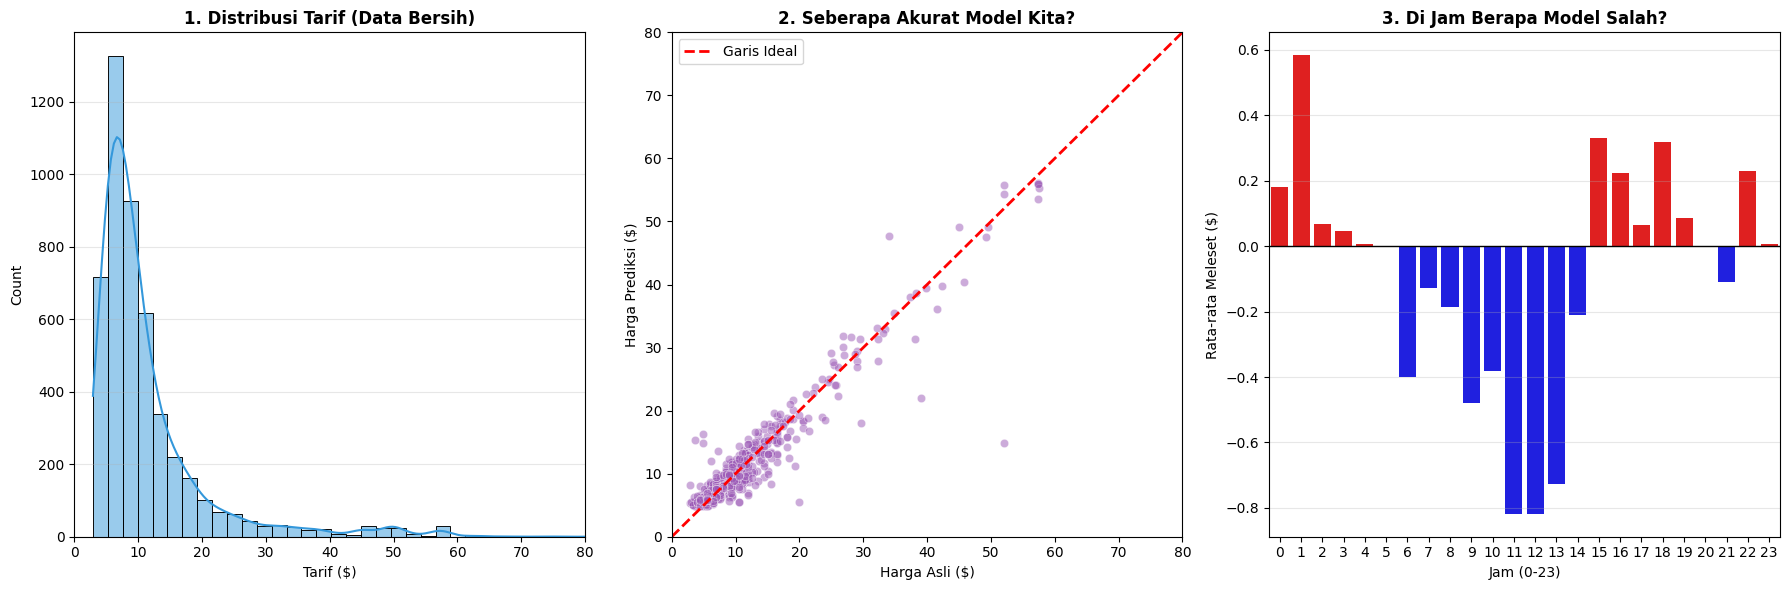

In [47]:
print("Menyiapkan data untuk visualisasi...")

#1. Data Histogram
pdf_dist = df_py_cleaned.select("fare_amount").sample(withReplacement=False, fraction=0.1, seed = 42).toPandas()

# 2. Data untuk Scatter Plot (Actual vs Predicted)
pdf_pred = df_with_error.sample(withReplacement=False, fraction=0.05, seed=42).limit(1000).toPandas()

# 3. Data untuk Bar Chart (Rata-rata Error per Jam)
pdf_error_hour = df_with_error.groupBy("hour") \
    .agg(F.avg("error").alias("avg_error")) \
    .orderBy("hour") \
    .toPandas()

print("Membuat Plot...")

plt.figure(figsize=(18, 6))

#PLOT 1: Distribusi Tarif (Bukti Data Bersih)
plt.subplot(1, 3, 1)
sns.histplot(pdf_dist['fare_amount'], bins=40, kde=True, color='#3498db')
plt.title('1. Distribusi Tarif (Data Bersih)', fontsize=12, fontweight='bold')
plt.xlabel('Tarif ($)')
plt.xlim(0, 80)
plt.grid(axis='y', alpha=0.3)

#PLOT 2: Evaluasi Model (Actual vs Predicted)
plt.subplot(1, 3, 2)
sns.scatterplot(x='label', y='prediction', data=pdf_pred, alpha=0.5, color='#9b59b6')
# Garis Merah (Prediksi Sempurna)
max_val = 80 # Batasi biar rapi
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Garis Ideal')
plt.title('2. Seberapa Akurat Model Kita?', fontsize=12, fontweight='bold')
plt.xlabel('Harga Asli ($)')
plt.ylabel('Harga Prediksi ($)')
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.legend()

#PLOT 3: Analisis Kesalahan per Jam (Insight Utama)
plt.subplot(1, 3, 3)
colors = ['red' if x > 0 else 'blue' for x in pdf_error_hour['avg_error']]
sns.barplot(x='hour', y='avg_error', data=pdf_error_hour, palette=colors)
plt.axhline(0, color='black', linewidth=1)
plt.title('3. Di Jam Berapa Model Salah?', fontsize=12, fontweight='bold')
plt.xlabel('Jam (0-23)')
plt.ylabel('Rata-rata Meleset ($)')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()